## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values

def set_cons(cons):
    global df
    
    names = []
    stretchs = []
    stretchs_err = []
    redshifts = []
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        if survey != 'SNF':
            infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
            py += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])

    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(z_zcuts['SNF']))]
stretchs = list(x1_zcuts['SNF'])
stretchs_err = list(x1_err_zcuts['SNF'])
redshifts = list(z_zcuts['SNF'])
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

df_nc = set_cons(False)
df_c = set_cons(True)

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Utilisation de la classe _stretchevol_ pour le fit double total

In [4]:
evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(df_nc)

evol3G2M2S.GUESSVAL[3] = -1

evol3G2M2S.minimize()

evol3G2M2S.migrad_out[1]

###################################################

evol3G2M2S_cons = stretchevol.Evol3G2M2S()
evol3G2M2S_cons.set_data(df_c)

evol3G2M2S_cons.GUESSVAL[3] = -1

evol3G2M2S_cons.minimize()

evol3G2M2S_cons.migrad_out[1]

#evol3G2M2S.plotter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | aa      |   -0.11   |    0.29   |            |            |         |         |       |
| 1 | mu_1    |   0.38    |   0.05    |            |            |         |         |       |
| 2 | sigma_1 |   0.60    |   0.04    |            |            |         |         |       |
| 3 | mu_2    |   -1.26   |    0.13   |            |            |         |         |       |
| 4 | sigma_2 |   0.53    |   0.08    |            |            |         |         |       |
---------------------------------------------------------------------------------------------

## Test without SNf Data

In [5]:
evol3G2M2S_nsnf = stretchevol.Evol3G2M2S()
evol3G2M2S_nsnf.set_data(df[df['survey'].isin(['SDSS','PS1','SNLS','HST'])])

evol3G2M2S_nsnf.minimize()

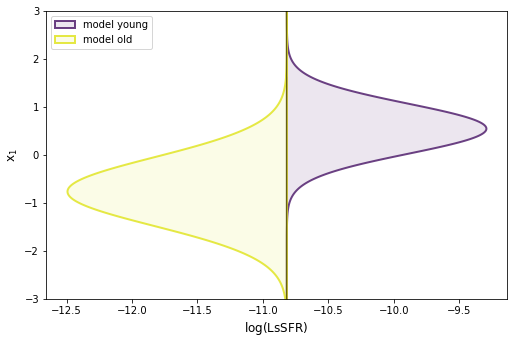

In [6]:
evol3G2M2S_nsnf.scatter()

## Get _a_ and _a-err_

In [22]:
aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S.migrad_out[1][0]['value'],
                               scale=evol3G2M2S.migrad_out[1][0]['error'],
                               size=1000)
a_list = evol3G2M2S.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

aa_list = scipy.stats.norm.rvs(loc=evol3G2M2S_cons.migrad_out[1][0]['value'],
                               scale=evol3G2M2S_cons.migrad_out[1][0]['error'],
                               size=1000)
a_list = evol3G2M2S_cons.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.404
vc = 0.508
vmax = 0.609
a = 0.51 ^ 0.1 _ -0.1
vmin = 0.382
vc = 0.464
vmax = 0.552
a = 0.46 ^ 0.09 _ -0.08


## Utilisation de la classe _stretchevol_ pour le fit double

In [5]:
reload(stretchevol)

evolSNF = stretchevol.Evol3G2M2S()
evolSNF.set_data(df[df['survey'] == 'SNF'])

evolSNF.minimize()

#fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/BiGaussian.pdf', bbox_inches='tight')

In [13]:
aa_list = scipy.stats.norm.rvs(loc=evolSNF.migrad_out[1][0]['value'],
                               scale=evolSNF.migrad_out[1][0]['error'],
                               size=1000)
a_list = evolSNF.get_a(aa_list)
vmin, vc, vmax = np.percentile(a_list, [16, 50, 84])

print('vmin =', round(vmin, 3))
print('vc =', round(vc, 3))
print('vmax =', round(vmax, 3))
print('a =', round(vc, 2), '^', round(vmax-vc, 2), '_', round(-(vc-vmin), 2))

vmin = 0.402
vc = 0.485
vmax = 0.56
a = 0.48 ^ 0.07 _ -0.08


## Défnition _age-law_

In [6]:
def delta(z):
    return stretchevol.MockEvol().delta(z)

with open('../../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(evol3G2M2S.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-evol3G2M2S.get_a(res_SNF['aa']))*res_SNF['mu_2']))

with open('../../Data/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - evol3G2M2S.get_a(res_ALL['aa']))*res_ALL['mu_2']))

def age_law_all_test(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S.param['aa'])*evol3G2M2S.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S.param['aa']))*evol3G2M2S.param['mu_2']))

def age_law_all_nsnf(z):
    """Analytical law with 3G2M2S results fitted without SNf"""
    return (delta(z)*evol3G2M2S_nsnf.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa'])*evol3G2M2S_nsnf.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_nsnf.param['aa']))*evol3G2M2S_nsnf.param['mu_2']))

def age_law_all_cons(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*evol3G2M2S_cons.param['mu_1']
      + (1-delta(z))*(evol3G2M2S.get_a(evol3G2M2S_cons.param['aa'])*evol3G2M2S_cons.param['mu_1']
                      + (1 - evol3G2M2S.get_a(evol3G2M2S_cons.param['aa']))*evol3G2M2S_cons.param['mu_2']))

def age_law_gen(z, param_hesse):
    """Function to get laws with parameters taken wrt there hesse error"""
    return (delta(z)*param_hesse[1]
      + (1-delta(z))*(evol3G2M2S.get_a(param_hesse[0])*param_hesse[1]
                      + (1 - evol3G2M2S.get_a(param_hesse[0]))*param_hesse[2]))

## Définition de _cov_ pour sélection aléatoire des paramètres

In [7]:
cov = im.Minuit.matrix(evol3G2M2S.m_tot)
mean = [evol3G2M2S.m_tot.values[i] for i in range(5)]
param_hesse_mat = scipy.stats.multivariate_normal.rvs(mean=mean, cov=cov, size=500)

cov_cons = im.Minuit.matrix(evol3G2M2S_cons.m_tot)
mean_cons = [evol3G2M2S_cons.m_tot.values[i] for i in range(5)]
param_hesse_mat_cons = scipy.stats.multivariate_normal.rvs(mean=mean_cons, cov=cov_cons, size=500)

cov_snf = im.Minuit.matrix(evolSNF.m_tot)
mean_snf = [evolSNF.m_tot.values[i] for i in range(5)]
param_hesse_mat_snf = scipy.stats.multivariate_normal.rvs(mean=mean_snf, cov=cov_snf, size=500)

### Only take _a_, _µ1_ and _µ2_

In [8]:
param_hesse_cut = param_hesse_mat[:,[0,1,3]]

param_hesse_cut_cons = param_hesse_mat_cons[:,[0,1,3]]

param_hesse_cut_snf = param_hesse_mat_snf[:,[0,1,3]]

### List of all the models

In [9]:
zlin = np.linspace(0, 2.65, 3000)
models_hesse = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut]
models_hesse = np.asarray(models_hesse)

models_hesse_cons = [[age_law_gen(zi, param_hesse_cons) for zi in zlin] for param_hesse_cons in param_hesse_cut_cons]
models_hesse_cons = np.asarray(models_hesse_cons)

models_hesse_snf = [[age_law_gen(zi, param_hesse) for zi in zlin] for param_hesse in param_hesse_cut_snf]
models_hesse_snf = np.asarray(models_hesse_snf)

### Take _std_

In [10]:
models_std = np.std(models_hesse, axis=0)

models_std_cons = np.std(models_hesse_cons, axis=0)

models_std_snf = np.std(models_hesse_snf, axis=0)

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [11]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

_, bins = np.histogram(df_nc.redshifts, histedges_equalN(df_nc.redshifts, 6))
_, bins_cons = np.histogram(df_c.redshifts, histedges_equalN(df_c.redshifts, 6))

### Tracé des points

In [12]:
slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((df_nc.redshifts > bins[i]) & (df_nc.redshifts <= bins[i+1])))
    x1_comp_mean[i] = np.mean(df_nc.stretchs.values[slices[i]])
    x1_comp_std[i] = np.std(df_nc.stretchs.values[slices[i]])
    z_comp_mean[i] = np.mean(df_nc.redshifts.values[slices[i]])
    z_comp_std[i] = np.std(df_nc.redshifts.values[slices[i]])

slices_cons = []
x1_comp_mean_cons = np.zeros(6)
x1_comp_std_cons = np.zeros(6)
z_comp_mean_cons = np.zeros(6)
z_comp_std_cons = np.zeros(6)

bins_text = bins
bins_text[-1] = 1.4
shift_slices = [[0.007, 0.0085],
                [0.008, 0.0115],
                [0.012, 0.017],
                [0.015, 0.023],
                [0.029, 0.040],
                [0.180, 0.210]]

for i in range(6):
    slices_cons.append(np.where((df_c.redshifts > bins[i]) & (df_c.redshifts <= bins[i+1])))
    x1_comp_mean_cons[i] = np.mean(df_c.stretchs.values[slices_cons[i]])
    x1_comp_std_cons[i] = np.std(df_c.stretchs.values[slices_cons[i]])
    z_comp_mean_cons[i] = np.mean(df_c.redshifts.values[slices_cons[i]])
    z_comp_std_cons[i] = np.std(df_c.redshifts.values[slices_cons[i]])

In [20]:
print('redshift_mean =', z_comp_mean[0])
print('stretch_mean =', x1_comp_mean[0], '±', x1_comp_std[0]/np.sqrt(len(df_nc.stretchs.values[slices[0]])))
print('redshift_mean =', z_comp_mean[-1])
print('stretch_mean =', x1_comp_mean[-1], '±', x1_comp_std[-1]/np.sqrt(len(df_nc.stretchs.values[slices[-1]])))

redshift_mean = 0.04789702967139894
stretch_mean = -0.1693993896725258 ± 0.09976585656176981
redshift_mean = 0.65033125
stretch_mean = 0.3354286768181818 ± 0.09727916274977488


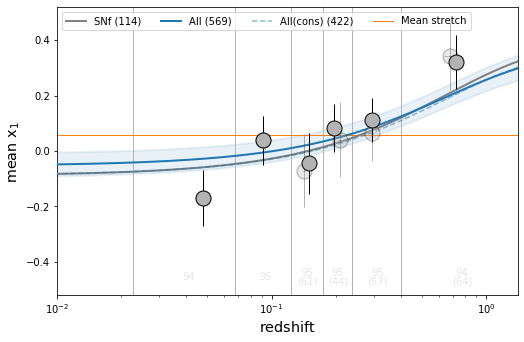

In [14]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop2 = dict(marker="o", ms=15, ecolor="0.7", mew=1, mec="0.5")
prop = dict(marker="o", ms=15, ecolor="k", mew=1, mec="k", mfc="0.7")

cmap = 'inferno'

#vmap_v = plt.cm.get_cmap(cmap)(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color="0.7", lw=1)

vmap_s = plt.cm.get_cmap(cmap)(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(df_nc.redshifts.values[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(df_nc.stretchs.values[slices[i]])),
               color=vmap_s[i], **prop, zorder=10, lw=1)

ax.plot(zlin, age_law_snf(zlin),
        color="0.5", lw=2, ls='-',
        label='SNf (114)', zorder=6)

#ax.fill_between(zlin, age_law_snf(zlin) + models_std_snf,
#                age_law_snf(zlin) - models_std_snf,
#                color="0.5", alpha=.1, lw=2)

ax.plot(zlin, age_law_all(zlin),
        color="C0", lw=2,
        label='All (569)', zorder=8)
##        label='Age-drift Model', zorder=8)

ax.fill_between(zlin, age_law_all(zlin) + models_std,
                age_law_all(zlin) - models_std,
                color="C0", alpha=.1, lw=2)

#ax.plot(zlin, age_law_all_nsnf(zlin),
#        color="0.5", lw=1, ls='-.',
#        label='All but SNf (455)', zorder=8)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#############################################################################################

for i in range(6):
    if len(df_nc.redshifts.values[slices[i]]) == len(df_c.redshifts.values[slices_cons[i]]):
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.465,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.1)
    else:
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][0], -0.45,
                str(len(df_nc.redshifts.values[slices[i]])), alpha=.1)
        ax.text((bins_text[i+1]+bins_text[i])/2-shift_slices[i][1], -0.48,
                '(' + str(len(df_c.redshifts.values[slices_cons[i]])) + ')', alpha=.1)

for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean_cons[i], x1_comp_mean_cons[i],
                xerr = z_comp_std_cons[i]/np.sqrt(len(df_c.redshifts.values[slices_cons[i]])),
                yerr = x1_comp_std_cons[i]/np.sqrt(len(df_c.stretchs.values[slices_cons[i]])),
                color=vmap_s[i], **prop, alpha=.3, zorder=9, lw=1)

ax.plot(zlin, age_law_all_cons(zlin),
        color="C0", lw=1.5, ls='--', alpha=.5,
        label='All(cons) (422)', zorder=7)

ax.hline(np.mean(df_nc.stretchs), color='C1', lw=1, ls='-', label='Mean stretch')

#############################################################################################

ax.set_ylim(-0.52, 0.52)
ax.set_xlim(0.01, 1.4)
ax.set_xscale('log')

ax.legend(ncol=4, loc='upper left')

fig.savefig('../../../../Images/stretchevol_all_vs_snf.pdf', bbox_inches='tight')
fig.savefig('../../../../Images/png/stretchevol_all_vs_snf.png', bbox_inches='tight', dpi=600)